# Heartbeat Sounds

### [Classifying heartbeat anomalies from stethoscope audio](https://www.kaggle.com/kinguistics/heartbeat-sounds)

### Imports

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa.display
import shutil
plt.ioff()

PATH = "C:\\Users\\frapo\\Downloads\\heartbeat-sounds"

### Functions

In [15]:
def load_wave(fname):
    y, sr = librosa.load(os.path.join(PATH, fname))
    return y

def build_dataset():
    path_to_ = os.path.join(PATH, "heartbeats.pkl")
    if os.path.isfile(path_to_):
        df = pd.read_pickle(path_to_)
    else:
        murmurs = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'murmur*.wav')]
        murmurs += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'murmur*.wav')]
        murmurs += murmurs
        labels = ["murmur"] * len(murmurs)
        
        normals = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'normal*.wav')]
        normals += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'normal*.wav')]
        labels += ["normal"] * len(normals)
        
        df = pd.DataFrame({"fname": murmurs+normals, "label": labels})
        df["array"] = df.fname.apply(load_wave)
        df["len_series"] = df["array"].apply(len)
        df['image_names'] = df.fname.apply(lambda x: x.replace("/", "-").replace("wav", "jpg"))
        df = df.sample(frac=1)
        df.to_pickle(path_to_)
    
    return df

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def explore_heartbeat(i):
    print(f"i: {i}")
    label = data.iloc[i].label
    fname = data.iloc[i].fname
    print(f"label: {label}; fname: {fname}")
    if label not in fname: return "Incostintent label"
    
    y, sr = librosa.load(os.path.join(PATH, fname))
    d = librosa.get_duration(y=y, sr=sr)
    print(f"Before padding sr: {sr}; len: {len(y)}; duration (s): {d}")
    
    y_ext = repeat_to_length(y, MAX_LEN)
    d = librosa.get_duration(y=y_ext, sr=sr)
    print(f"After padding sr: {sr}; len: {len(y_ext)}; duration: {d}")
    
    fig, ax = plt.subplots(figsize=(15, 3))
    librosa.display.waveplot(y, sr=sr)
    ax.set_title(f'label={label}; waveplot')
    
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: stft, amp2db, log')
    
    #my_dpi = 120
    #fig, ax = plt.subplots(figsize=(512/my_dpi, 512/my_dpi), dpi=my_dpi)
    
    mfccs = librosa.feature.mfcc(y, sr=sr)
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: mfcc, log')

    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)    
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: melspectrogram, amp2db, log, fmax=2k hz')
    
    plt.show()
    
    return fname, Xdb, y

def get_melspectrogram(y, sr):
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  
    return mel_spec_db

def produce_spect_image(spec, sr, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')    
    ax.axis('off')
    plt.savefig(name, bbox_inches=None, pad_inches=0)
    plt.close(fig)
    
def load_and_pad(fname):
    y, sr = librosa.load(fname)
    y = repeat_to_length(y, MAX_LEN)
    return y, sr

def save_spectrograms(df):
    
    directory = os.path.join(PATH, "spects")
    if os.path.exists(directory): shutil.rmtree(directory)
    os.makedirs(directory)
    
    for i, row in df.iterrows():
        fname = os.path.join(PATH, row.fname)
        image_name = os.path.join(directory, row.image_names)
        
        y, sr = load_and_pad(fname)
        spec = get_melspectrogram(y, sr)
        produce_spect_image(spec, sr, image_name)
        
    mxn = df.copy().reset_index()
    mxn["is_murmur"] = mxn.label.apply(lambda x: int(x == "murmur"))
    
    return mxn[["index", "is_murmur", "image_names"]]

def save_lst(x, name):
    x.to_csv(os.path.join(PATH, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(PATH, 'temp.lst'), "rt") as fin:
        with open(os.path.join(PATH, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

### Load dataset and explore

In [4]:
data = build_dataset()
MAX_LEN = max(data["len_series"])

assert MAX_LEN == 614468
assert isinstance(data.array[0].sum(), np.float32)
assert data.shape == (609, 5)

In [5]:
data.sample(5)

,fname,label,array,len_series,image_names
155,set_b/murmur_noisymurmur_292_1311185449649_D.wav,murmur,"[0.0039499905, 0.004215284, 0.0041980376, 0.00...",64078,set_b-murmur_noisymurmur_292_1311185449649_D.jpg
245,set_a/murmur__201108222237.wav,murmur,"[-0.007513616, -0.012031573, -0.011287979, -0....",174979,set_a-murmur__201108222237.jpg
198,set_b/murmur__211_1308163238707_C.wav,murmur,"[-0.008076959, -0.010186774, -0.012238381, -0....",62556,set_b-murmur__211_1308163238707_C.jpg
608,set_a/normal__201108011118.wav,normal,"[-0.002232234, -0.0035923335, -0.00330892, -0....",174979,set_a-normal__201108011118.jpg
31,set_b/murmur__112_1306243000964_D.wav,murmur,"[0.051644217, 0.058486793, 0.06327166, 0.06612...",336963,set_b-murmur__112_1306243000964_D.jpg


i: 380
label: normal; fname: set_b/normal__168_1307970069434_A2.wav
Before padding sr: 22050; len: 146120; duration (s): 6.626757369614513
After padding sr: 22050; len: 614468; duration: 27.86702947845805


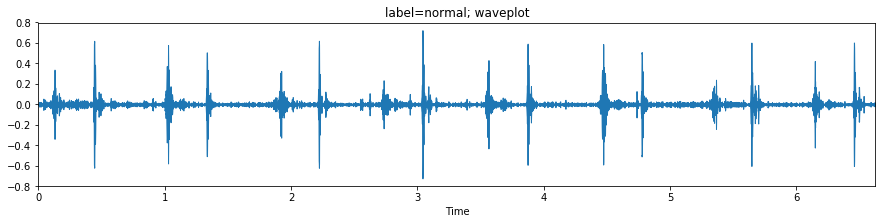

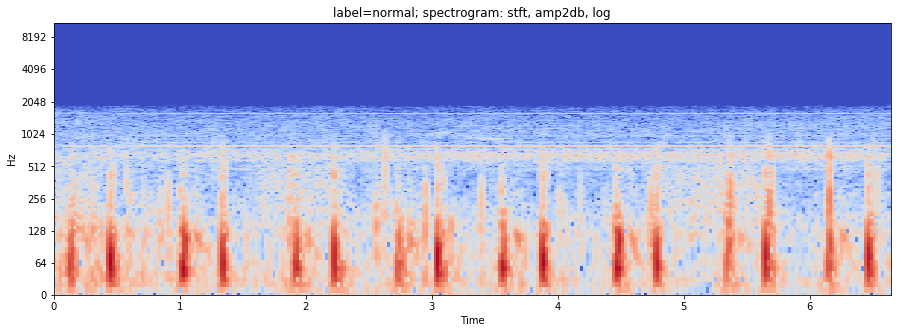

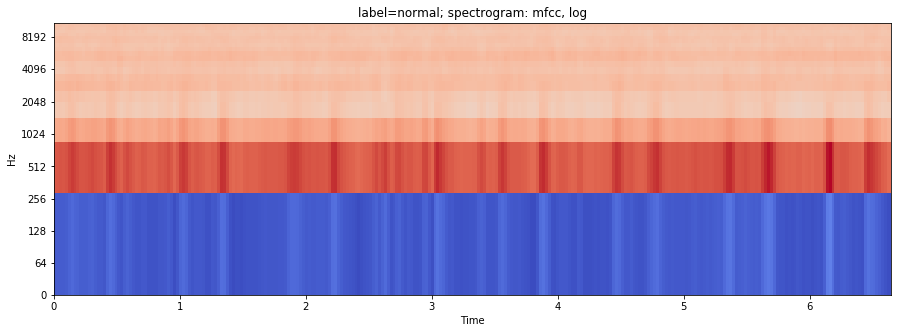

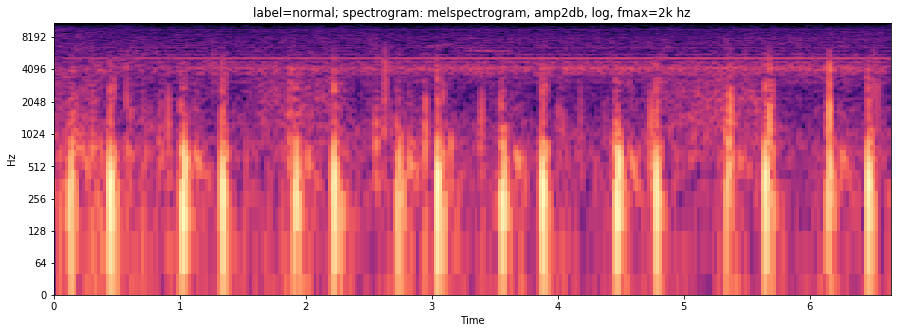

In [6]:
i = np.random.randint(low=0, high=(len(data)-1))
fname, Xdb, y = explore_heartbeat(i)
ipd.Audio(os.path.join(PATH, fname))

### Prepare dataset for deep learning

In [11]:
lst = save_spectrograms(data)

In [13]:
assert lst.shape[0] == data.shape[0]

In [17]:
raw_train = lst.sample(int(len(lst)*.8), random_state=42).sample(frac=1)
raw_valid = lst.loc[~lst.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

((487, 3), (122, 3))

In [20]:
raw_train.is_murmur.sum()/len(raw_train), raw_valid.is_murmur.sum()/len(raw_valid)

(0.4394250513347023, 0.36065573770491804)

In [21]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [25]:
! head {PATH}\train.lst

'head' is not recognized as an internal or external command,
operable program or batch file.
